# Combined buoy and Hindcast Dataframe
Create a dataframe by combining cleaned historical buoy data, with features from Hindcast data that was given as grid point close to location of buoy data. 

Features to take note of are:
- ETOT; Total variance of total spectrum (M^2) 
- ETTSea
- ETTSw
- VMD; Vector Mean Direction: direction to wich waves are traveling, clockwise from north in degrees
- VMDSw; 
- VMDSea

In wave spectral analysis locally generated wind waves are refered to as seas and waves travelling from distant sources are refered to as swell. Generally seas contain shorter periods and steeper waves and swells contain longer period and less steep waves. https://natural-resources.canada.ca/sites/www.nrcan.gc.ca/files/canmetenergy/files/pubs/CHC-TR-051.pdf
From the Hindcast grid point , ETOT refers to the total energy in the total spectrum (sea and swell combined) Then there is the separate Energy from the Sea and Swell . 

All features will be included to start, then columns that are not relevent may be dropped. 

The data will be combined on the datetime so that they align. Hindcast data is give for three hour intervals, as such missing values will be imputed using forward fill, so hour intervals will contain the same value for the three hour interval. 

Possibly look into imputing NaN values using interpolation instead. 

Possible inclusion of tidal data: Consideration, tidal data measured from land station and not same location. 

### Location of buoy and Hindcast gridpoint coordinates

- **Laperouse buoy**: 
   - 48.840 N 126.000 W (48°50'24" N 126°0'0" W)
   - Site elevation: sea level
   -  Anemometer height: 5 m above site elevation
   - Water depth: 72 m
- **Grid Point: GN018918**:
   - Latitude: 48.7500
   - Longitude: -126.2500
   - Depth: 432.1110 (*find out if depth is meters or feet)

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#import gridpoint data from gridpoint closest to buoy. 
file_path = '../Data/HINDCAST_MSC50/GN018918.opr_dump'
with open(file_path, 'r') as file:
    data1 = file.read()

In [3]:
column_names = ["CCYYMM", "DDHHmm", "WD", "WS", "ETOT", "TP", "VMD", "ETTSea", "TPSea", "VMDSea", 
                "ETTSw", "TPSw", "VMDSw", "MO1", "MO2", "HS", "DMDIR", "ANGSPR", "INLINE"]

# Read data into a DataFrame
df_hind = pd.read_csv(file_path, skiprows=25, delim_whitespace=True, names=column_names)

In [4]:
df_hind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105190 entries, 0 to 105189
Data columns (total 19 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   CCYYMM  105190 non-null  int64  
 1   DDHHmm  105190 non-null  int64  
 2   WD      105190 non-null  float64
 3   WS      105190 non-null  float64
 4   ETOT    105190 non-null  float64
 5   TP      105190 non-null  float64
 6   VMD     105190 non-null  float64
 7   ETTSea  105190 non-null  float64
 8   TPSea   105190 non-null  float64
 9   VMDSea  105190 non-null  float64
 10  ETTSw   105190 non-null  float64
 11  TPSw    105190 non-null  float64
 12  VMDSw   105190 non-null  float64
 13  MO1     105190 non-null  float64
 14  MO2     105190 non-null  float64
 15  HS      105190 non-null  float64
 16  DMDIR   105190 non-null  float64
 17  ANGSPR  105190 non-null  float64
 18  INLINE  105190 non-null  float64
dtypes: float64(17), int64(2)
memory usage: 15.2 MB


In [5]:
df_hind[['CCYYMM','DDHHmm']]

,CCYYMM,DDHHmm
0,198001,10600
1,198001,10900
2,198001,11200
3,198001,11500
4,198001,11800
...,...,...
105185,201512,310900
105186,201512,311200
105187,201512,311500
105188,201512,311800


In [6]:
#use zfill() as it adds zeros to the begining of the string, to add 0 to days 1-9 for each month. 
#convert DDHHmm to string first to use zfill()
df_hind['DDHHmm'] = df_hind['DDHHmm'].astype(str).str.zfill(6) #ensures 6 characters and will add 0 to beginning if not

In [7]:
df_hind['DDHHmm']

0         010600
1         010900
2         011200
3         011500
4         011800
           ...  
105185    310900
105186    311200
105187    311500
105188    311800
105189    312100
Name: DDHHmm, Length: 105190, dtype: object

In [8]:
def process_datetime_columns(df, CCYYMM_col, DDHHmm_col):
    # Convert 'CCYYMM' and 'DDHHmm' to datetime format and combine into one column
    df['year_month'] = pd.to_datetime(df[CCYYMM_col].astype(str), format='%Y%m')
    
    # Extract components of day, hour, and minute, convert to string to slice, then convert back to int
    df['DDHHmm_str'] = df[DDHHmm_col].astype(str)
    df['day'] = df['DDHHmm_str'].str[:2].astype(int)
    df['hour'] = df['DDHHmm_str'].str[2:4].astype(int)
    df['minute'] = df['DDHHmm_str'].str[4:].astype(int)

    # Convert each component into timedelta to be combined with date time
    day_timedelta = pd.to_timedelta(df['day'], unit='D')
    hour_timedelta = pd.to_timedelta(df['hour'], unit='H')
    minute_timedelta = pd.to_timedelta(df['minute'], unit='m')

    # Combine into one column
    df['Datetime'] = pd.to_datetime(df['year_month']) + day_timedelta + hour_timedelta + minute_timedelta

    # Drop specified columns
    df = df.drop(['year_month', 'CCYYMM', 'DDHHmm', 'DDHHmm_str', 'day', 'hour', 'minute'], axis=1)

    return df


In [9]:
df_hind = process_datetime_columns(df_hind, 'CCYYMM', 'DDHHmm')

In [10]:
df_hind['Datetime']

0        1980-01-02 06:00:00
1        1980-01-02 09:00:00
2        1980-01-02 12:00:00
3        1980-01-02 15:00:00
4        1980-01-02 18:00:00
                 ...        
105185   2016-01-01 09:00:00
105186   2016-01-01 12:00:00
105187   2016-01-01 15:00:00
105188   2016-01-01 18:00:00
105189   2016-01-01 21:00:00
Name: Datetime, Length: 105190, dtype: datetime64[ns]

In [11]:
#import historical buoy data
df_buoy = pd.read_csv('../Data/buoy_data/laperouse_stn46206_clean.csv')

In [12]:
df_buoy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237882 entries, 0 to 237881
Data columns (total 19 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   STN_ID     237882 non-null  object 
 1   DATE       237882 non-null  object 
 2   Q_FLAG     237882 non-null  int64  
 3   LATITUDE   237882 non-null  float64
 4   LONGITUDE  237882 non-null  float64
 5   DEPTH      237882 non-null  float64
 6   VWH$       237882 non-null  float64
 7   VCMX       237882 non-null  float64
 8   VTP$       237882 non-null  float64
 9   WDIR       237882 non-null  float64
 10  WSPD       237882 non-null  float64
 11  GSPD       237882 non-null  float64
 12  WDIR.1     237882 non-null  float64
 13  WSPD.1     237882 non-null  float64
 14  GSPD.1     237882 non-null  float64
 15  ATMS       237882 non-null  float64
 16  DRYT       237882 non-null  float64
 17  SSTP       237882 non-null  float64
 18  YEAR       237882 non-null  int64  
dtypes: float64(15), int64(2

In [13]:
#convert Date to datetime and rename "Datetime"
df_buoy['DATE']=pd.to_datetime(df_buoy['DATE'])
df_buoy=df_buoy.rename(columns ={'DATE':'Datetime'})

In [14]:
df_buoy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237882 entries, 0 to 237881
Data columns (total 19 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   STN_ID     237882 non-null  object        
 1   Datetime   237882 non-null  datetime64[ns]
 2   Q_FLAG     237882 non-null  int64         
 3   LATITUDE   237882 non-null  float64       
 4   LONGITUDE  237882 non-null  float64       
 5   DEPTH      237882 non-null  float64       
 6   VWH$       237882 non-null  float64       
 7   VCMX       237882 non-null  float64       
 8   VTP$       237882 non-null  float64       
 9   WDIR       237882 non-null  float64       
 10  WSPD       237882 non-null  float64       
 11  GSPD       237882 non-null  float64       
 12  WDIR.1     237882 non-null  float64       
 13  WSPD.1     237882 non-null  float64       
 14  GSPD.1     237882 non-null  float64       
 15  ATMS       237882 non-null  float64       
 16  DRYT       237882 no

# Join Hindcast Data and Buoy Data

In [15]:
#check for duplicates in datetime columns 
duplicates_buoy_date =df_buoy['Datetime'].duplicated().sum()
duplicates_hind_date =df_hind['Datetime'].duplicated().sum()
print('duplicates date buoy data:', duplicates_buoy_date)
print('duplicates date hindcast data:',duplicates_hind_date)



duplicates date buoy data: 0
duplicates date hindcast data: 0


In [16]:
#create column to join df_buoy and df_hind, excluding minutes
df_buoy['DATE'] = df_buoy['Datetime'].dt.strftime('%Y-%m-%d %H')
df_hind['DATE'] = df_hind['Datetime'].dt.strftime('%Y-%m-%d %H') 


In [17]:
print(df_buoy['DATE'].describe())
print(df_hind['DATE'].describe())
#df_buoy will have less unique values because minutes are now taken out of record and it is just to the hour.

count            237882
unique           237347
top       2009-04-18 04
freq                  2
Name: DATE, dtype: object
count            105190
unique           105190
top       1980-01-02 06
freq                  1
Name: DATE, dtype: object


In [18]:
#join df_hind to df_buoy using left join: all rows in df_buoy will be in resulting data frame,
#with corresponding rows from df_hind
main_df = pd.merge(df_buoy, df_hind, how = 'left', on = 'DATE')

In [19]:
main_df.head(20)

,STN_ID,Datetime_x,Q_FLAG,LATITUDE,LONGITUDE,DEPTH,VWH$,VCMX,VTP$,WDIR,...,ETTSw,TPSw,VMDSw,MO1,MO2,HS,DMDIR,ANGSPR,INLINE,Datetime_y
0,C46206,1988-11-22 22:34:00,1,48.83,126.0,73.0,5.42,8.4,11.64,234.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1,C46206,1988-11-23 00:33:00,1,48.83,126.0,73.0,5.89,9.0,14.22,263.0,...,0.844,12.229,63.7,0.682,0.564,3.981,67.0,0.8075,0.7153,1988-11-23 00:00:00
2,C46206,1988-11-23 01:34:00,1,48.83,126.0,73.0,6.49,10.5,12.80,277.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
3,C46206,1988-11-23 02:34:00,1,48.83,126.0,73.0,7.34,12.1,15.06,275.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
4,C46206,1988-11-23 04:34:00,1,48.83,126.0,73.0,7.71,13.0,14.22,295.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
5,C46206,1988-11-23 05:34:00,1,48.83,126.0,73.0,8.05,13.9,14.22,288.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
6,C46206,1988-11-23 06:34:00,1,48.83,126.0,73.0,8.51,17.5,16.00,281.0,...,0.707,13.729,83.1,0.867,0.793,4.366,70.9,0.7644,0.6795,1988-11-23 06:00:00
7,C46206,1988-11-23 07:34:00,1,48.83,126.0,73.0,8.70,13.9,15.06,297.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
8,C46206,1988-11-23 08:34:00,1,48.83,126.0,73.0,7.23,13.3,16.00,283.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
9,C46206,1988-11-23 09:34:00,1,48.83,126.0,73.0,7.32,12.2,16.00,289.0,...,0.800,14.450,82.6,1.161,1.093,4.952,67.1,0.7056,0.6109,1988-11-23 09:00:00


## Drop rows outside of overlapping time range and impute NaN values
Appears that data frames have merged successfully with NaN values approximately inbetween every third row as expected with frequency of DATE in df_hind being 3 hour intervals. 

Next NaN values will be imputed using forward fill method so values given for each three hour interval will be the same for each hour in that interval. **Come back and possibly use interpolate instead**

In [20]:
#max date from df_hind
main_df['Datetime_y'].max()

Timestamp('2016-01-01 21:00:00')

In [21]:
#drop rows outside of datetime_y range
max_datetime_x =main_df['Datetime_y'].max()
main_df = main_df[main_df['Datetime_x'] <= max_datetime_x].copy()



In [22]:
main_df.head(20)

,STN_ID,Datetime_x,Q_FLAG,LATITUDE,LONGITUDE,DEPTH,VWH$,VCMX,VTP$,WDIR,...,ETTSw,TPSw,VMDSw,MO1,MO2,HS,DMDIR,ANGSPR,INLINE,Datetime_y
0,C46206,1988-11-22 22:34:00,1,48.83,126.0,73.0,5.42,8.4,11.64,234.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1,C46206,1988-11-23 00:33:00,1,48.83,126.0,73.0,5.89,9.0,14.22,263.0,...,0.844,12.229,63.7,0.682,0.564,3.981,67.0,0.8075,0.7153,1988-11-23 00:00:00
2,C46206,1988-11-23 01:34:00,1,48.83,126.0,73.0,6.49,10.5,12.80,277.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
3,C46206,1988-11-23 02:34:00,1,48.83,126.0,73.0,7.34,12.1,15.06,275.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
4,C46206,1988-11-23 04:34:00,1,48.83,126.0,73.0,7.71,13.0,14.22,295.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
5,C46206,1988-11-23 05:34:00,1,48.83,126.0,73.0,8.05,13.9,14.22,288.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
6,C46206,1988-11-23 06:34:00,1,48.83,126.0,73.0,8.51,17.5,16.00,281.0,...,0.707,13.729,83.1,0.867,0.793,4.366,70.9,0.7644,0.6795,1988-11-23 06:00:00
7,C46206,1988-11-23 07:34:00,1,48.83,126.0,73.0,8.70,13.9,15.06,297.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
8,C46206,1988-11-23 08:34:00,1,48.83,126.0,73.0,7.23,13.3,16.00,283.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
9,C46206,1988-11-23 09:34:00,1,48.83,126.0,73.0,7.32,12.2,16.00,289.0,...,0.800,14.450,82.6,1.161,1.093,4.952,67.1,0.7056,0.6109,1988-11-23 09:00:00


In [23]:
main_df['Datetime_x'].max()

Timestamp('2016-01-01 20:38:00')

In [24]:
main_df['Datetime_x'].min()

Timestamp('1988-11-22 22:34:00')

In [25]:
main_df.shape

(199026, 38)

In [26]:
main_df.tail(10)

,STN_ID,Datetime_x,Q_FLAG,LATITUDE,LONGITUDE,DEPTH,VWH$,VCMX,VTP$,WDIR,...,ETTSw,TPSw,VMDSw,MO1,MO2,HS,DMDIR,ANGSPR,INLINE,Datetime_y
199016,C46206,2016-01-01 11:38:00,1,48.83,126.0,72.0,2.8,4.2,14.2,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
199017,C46206,2016-01-01 12:38:00,1,48.83,126.0,72.0,2.9,4.7,6.4,121.0,...,0.255,13.984,73.8,0.330,0.382,2.426,87.8,0.3785,0.7548,2016-01-01 12:00:00
199018,C46206,2016-01-01 13:38:00,1,48.83,126.0,72.0,3.2,5.5,6.7,116.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
199019,C46206,2016-01-01 14:38:00,1,48.83,126.0,72.0,3.0,6.2,6.6,114.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
199020,C46206,2016-01-01 15:38:00,1,48.83,126.0,72.0,3.0,5.7,6.6,121.0,...,0.214,14.541,73.7,0.374,0.446,2.503,90.4,0.2799,0.7389,2016-01-01 15:00:00
199021,C46206,2016-01-01 16:38:00,1,48.83,126.0,72.0,2.7,4.6,15.1,126.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
199022,C46206,2016-01-01 17:38:00,1,48.83,126.0,72.0,2.9,4.2,15.1,125.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
199023,C46206,2016-01-01 18:38:00,1,48.83,126.0,72.0,2.8,5.1,6.9,133.0,...,0.185,14.839,73.1,0.411,0.496,2.585,275.6,0.3261,0.7159,2016-01-01 18:00:00
199024,C46206,2016-01-01 19:38:00,1,48.83,126.0,72.0,2.8,4.8,6.6,129.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
199025,C46206,2016-01-01 20:38:00,1,48.83,126.0,72.0,2.8,3.9,14.2,123.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [27]:
#use forward fill to impute NaN values with same value for 3 hour interval. 
main_df = main_df.fillna(method='ffill') #possibly come back and use interpolate

In [28]:
main_df.head(20)

,STN_ID,Datetime_x,Q_FLAG,LATITUDE,LONGITUDE,DEPTH,VWH$,VCMX,VTP$,WDIR,...,ETTSw,TPSw,VMDSw,MO1,MO2,HS,DMDIR,ANGSPR,INLINE,Datetime_y
0,C46206,1988-11-22 22:34:00,1,48.83,126.0,73.0,5.42,8.4,11.64,234.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1,C46206,1988-11-23 00:33:00,1,48.83,126.0,73.0,5.89,9.0,14.22,263.0,...,0.844,12.229,63.7,0.682,0.564,3.981,67.0,0.8075,0.7153,1988-11-23 00:00:00
2,C46206,1988-11-23 01:34:00,1,48.83,126.0,73.0,6.49,10.5,12.80,277.0,...,0.844,12.229,63.7,0.682,0.564,3.981,67.0,0.8075,0.7153,1988-11-23 00:00:00
3,C46206,1988-11-23 02:34:00,1,48.83,126.0,73.0,7.34,12.1,15.06,275.0,...,0.844,12.229,63.7,0.682,0.564,3.981,67.0,0.8075,0.7153,1988-11-23 00:00:00
4,C46206,1988-11-23 04:34:00,1,48.83,126.0,73.0,7.71,13.0,14.22,295.0,...,0.844,12.229,63.7,0.682,0.564,3.981,67.0,0.8075,0.7153,1988-11-23 00:00:00
5,C46206,1988-11-23 05:34:00,1,48.83,126.0,73.0,8.05,13.9,14.22,288.0,...,0.844,12.229,63.7,0.682,0.564,3.981,67.0,0.8075,0.7153,1988-11-23 00:00:00
6,C46206,1988-11-23 06:34:00,1,48.83,126.0,73.0,8.51,17.5,16.00,281.0,...,0.707,13.729,83.1,0.867,0.793,4.366,70.9,0.7644,0.6795,1988-11-23 06:00:00
7,C46206,1988-11-23 07:34:00,1,48.83,126.0,73.0,8.70,13.9,15.06,297.0,...,0.707,13.729,83.1,0.867,0.793,4.366,70.9,0.7644,0.6795,1988-11-23 06:00:00
8,C46206,1988-11-23 08:34:00,1,48.83,126.0,73.0,7.23,13.3,16.00,283.0,...,0.707,13.729,83.1,0.867,0.793,4.366,70.9,0.7644,0.6795,1988-11-23 06:00:00
9,C46206,1988-11-23 09:34:00,1,48.83,126.0,73.0,7.32,12.2,16.00,289.0,...,0.800,14.450,82.6,1.161,1.093,4.952,67.1,0.7056,0.6109,1988-11-23 09:00:00


In [29]:
main_df.isnull().sum()

STN_ID        0
Datetime_x    0
Q_FLAG        0
LATITUDE      0
LONGITUDE     0
DEPTH         0
VWH$          0
VCMX          0
VTP$          0
WDIR          0
WSPD          0
GSPD          0
WDIR.1        0
WSPD.1        0
GSPD.1        0
ATMS          0
DRYT          0
SSTP          0
YEAR          0
DATE          0
WD            1
WS            1
ETOT          1
TP            1
VMD           1
ETTSea        1
TPSea         1
VMDSea        1
ETTSw         1
TPSw          1
VMDSw         1
MO1           1
MO2           1
HS            1
DMDIR         1
ANGSPR        1
INLINE        1
Datetime_y    1
dtype: int64

In [30]:
#use back fill to impute Null values in the first row from the row below
main_df = main_df.fillna(method='bfill')


In [31]:
main_df.isnull().sum()

STN_ID        0
Datetime_x    0
Q_FLAG        0
LATITUDE      0
LONGITUDE     0
DEPTH         0
VWH$          0
VCMX          0
VTP$          0
WDIR          0
WSPD          0
GSPD          0
WDIR.1        0
WSPD.1        0
GSPD.1        0
ATMS          0
DRYT          0
SSTP          0
YEAR          0
DATE          0
WD            0
WS            0
ETOT          0
TP            0
VMD           0
ETTSea        0
TPSea         0
VMDSea        0
ETTSw         0
TPSw          0
VMDSw         0
MO1           0
MO2           0
HS            0
DMDIR         0
ANGSPR        0
INLINE        0
Datetime_y    0
dtype: int64

In [32]:
main_df.to_csv('combined_buoy_hindcast.csv', index=False)


# EDA and Visualization

In [33]:
#Datetime range of Data
min_date =main_df['DATE'].min()
max_date = main_df['DATE'].max()
print('Date Range of Data Frame:',min_date, 'to',max_date)


Date Range of Data Frame: 1988-11-22 22 to 2016-01-01 20


**Target Varibale(s):** Wave energy as defined by ETOT, Wave height and Wave period of total spectrum. 
- possibly look into wave power available as target variable, derived from power equation. 
- Look at distributions of wave energy wave period and wave height
- What is afffecting or correlated linearly with these variables? What are the relationships? 

### Data Dictionary
**Note on Directions;** Directions are given in degrees corresponding to True North: 
North (N): 0° = 360°
East (E): 90°
South (S): 180°
West (W): 270°

- Index, - DATE : Date time excluding minutes, both df_buoy and df_hind joined on this column.
- STN_ID: buoy station ID.
- Datetime_x: Datetime from df_buoy
- DEPTH: Depth in meters.
- VWH\$: Characteristic significant wave height (reported by the buoy) (m)
- VCMX: Maximum zero crossing wave height (reported by the buoy) (m)
- VTP\$: Wave spectrum peak period (reported by the buoy) (s)
- WDIR: Direction from which the wind is blowing (° True)
- WSPD: Horizontal wind speed (m/s)
- WSS\$:Horizontal scalar wind speed (m/s)
- GSPD: Gust wind speed (m/s)
- ATMS: Atmospheric pressure at sea level (mbar)
- DRYT: Dry bulb temperature (air temperature) (°C)
- SSTP: Sea surface temperature (°C)
- Q_FLAG: 0
    - Blank - No quality control (QC) has been performed
    - 1- Good - QC has been performed: record appears correct
    - 3-Doubtful - QC has been performed: record appears doubtful
    - 4-Erroneous - QC has been performed: record appears erroneous
    - 5-Changes - The record has been changed as a result of QC
    - 6-Acceptable - QC has been performed: record seems inconsistent with other records
    - 7-Off Position - There is a problem with the buoy position or mooring. Data may still be useful.
    - 8-Reserved
    - 9-Reserved - indicates missing elements
 - Datetime_y  - Date time in 3 hour intervals from df_hind
 - WD          - Wind Direction (deg from which wind is blowing (° True))
 - WS          - Wind Speed (m/s)
 - ETOT        - Total Variance of Total Spectrum (m^2)
 - TP          - Peak Spectral Period of Total Spectrum (sec)
 - VMD         - Vector Mean Direction of Total Spectrum (deg to which)
 - ETTSea      - Total Variance of Primary Partition (m^2)
 - TPSea       - Peak Spectral Period of Primary Partition (sec)
 - VMDSea      - Vector Mean Direction of Primary Partition (deg to which)
 - ETTSw       - Total Variance of Secondary Partition (m^2)
 - TPSw        - Peak Spectral Period of Secondary Partition (sec)
 - VMDSw       - Vector Mean Direction of Secondary Partition (deg to which)
 - MO1         - First Spectral Moment of Total Spectrum (m^2/s)
 - MO2         - Second Spectral Moment of Total Spectrum (m^2/s^2)
 - HS          - Significant Wave Height (m)
 - DMDIR       - Dominant Direction (deg to which)
 - ANGSPR      - Angular Spreading Function
 - INLINE      - In-Line Variance Ratio
 


In [34]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199026 entries, 0 to 199025
Data columns (total 38 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   STN_ID      199026 non-null  object        
 1   Datetime_x  199026 non-null  datetime64[ns]
 2   Q_FLAG      199026 non-null  int64         
 3   LATITUDE    199026 non-null  float64       
 4   LONGITUDE   199026 non-null  float64       
 5   DEPTH       199026 non-null  float64       
 6   VWH$        199026 non-null  float64       
 7   VCMX        199026 non-null  float64       
 8   VTP$        199026 non-null  float64       
 9   WDIR        199026 non-null  float64       
 10  WSPD        199026 non-null  float64       
 11  GSPD        199026 non-null  float64       
 12  WDIR.1      199026 non-null  float64       
 13  WSPD.1      199026 non-null  float64       
 14  GSPD.1      199026 non-null  float64       
 15  ATMS        199026 non-null  float64       
 16  DRYT   

In [35]:
#convert Column "DATE" to datetime
main_df['DATE']=pd.to_datetime(main_df['DATE'])

### Distributions of Target variables and Other Variables; Wind Direction, Speed and Vector Wave Direction

Note: Resampling to a common interval may introduce biases if the original data had irregularities or specific patterns. 

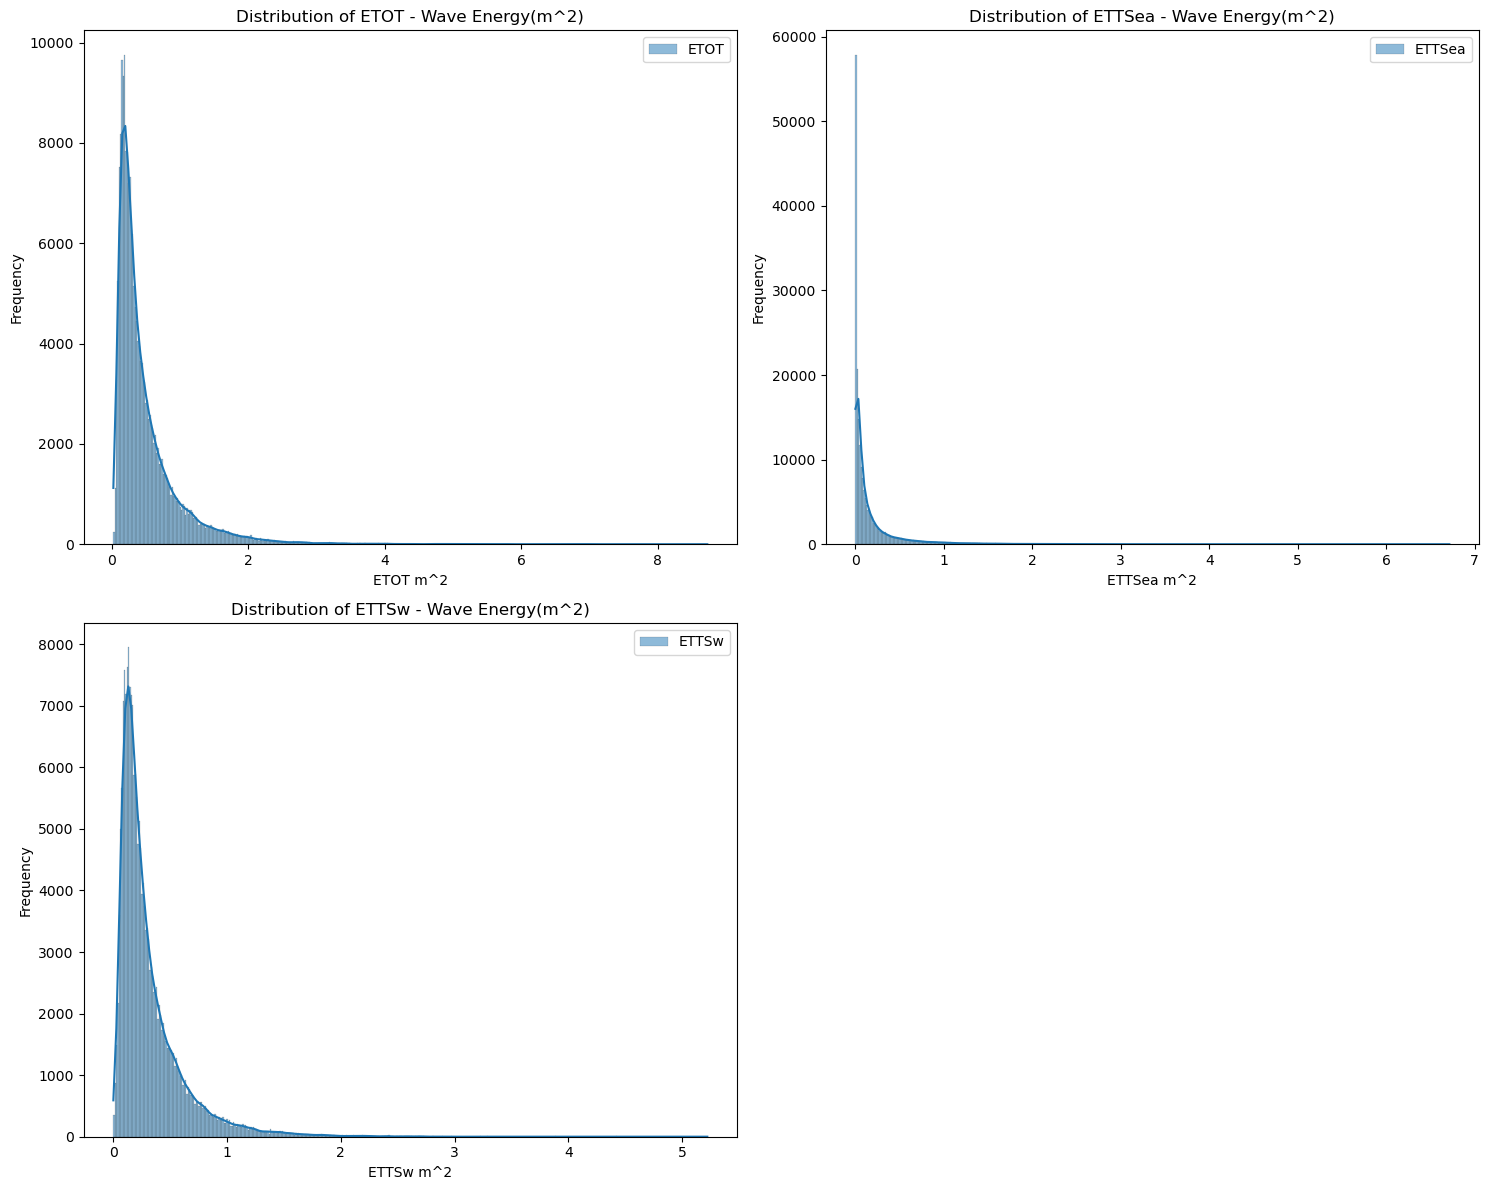

In [36]:
columns_to_plot_energy = ['ETOT','ETTSea','ETTSw']

#Create parameters so there are 2 subplots per row
num_variables = len(columns_to_plot_energy)
num_rows = (num_variables//2)+(num_variables %2) #modulo 2 if there is remainder (odd number) will be another row

plt.figure(figsize=(15,num_rows *6))

for idx, col in enumerate (columns_to_plot_energy, 1): 
    #create subplots with up to 2 subplots in the same row
    plt.subplot(num_rows, min(2, num_variables), idx) #idx is index of current subplot
    #select data for current column
    wave_energy = main_df[col]
    bin_num = int(np.ceil(np.sqrt(len(main_df))))
    #plot historgram for current column
    sns.histplot(wave_energy, edgecolor='black', bins=bin_num, label = col, kde=True)
    
    #labeling
    plt.title(f'Distribution of {col} - Wave Energy(m^2)')
    plt.xlabel(f'{col} m^2')
    plt.ylabel('Frequency')
    
    plt.legend()
    
plt.tight_layout()
plt.show()
               
    

In [37]:
main_df[['ETOT','ETTSea', 'ETTSw']].describe()

,ETOT,ETTSea,ETTSw
count,199026.000000,199026.00000,199026.000000
mean,0.498808,0.17810,0.320705
std,0.518605,0.35998,0.304202
min,0.022000,0.00000,0.002000
25%,0.188000,0.01200,0.132000
50%,0.324000,0.05300,0.222000
75%,0.613000,0.17700,0.401000
max,8.726000,6.71300,5.221000


In looking at distribution of ETOT(target variable), as well as ETTSea and ETTSw, they all appear to be positively skewed. For all three the mean > median. Will leave outliers as is for now. These variables are roughly proportional to energy and it makes sense that there could be unusually large waves resulting in large values for Energy. 
ETOT is the total variance of total spectrum, while ETTSea is the variance in Sea swell which is mainly generated from local winds; reffered to as sea state. ETTSw is variance in swell generated from larger storms travelling longer distances(https://natural-resources.canada.ca/sites/www.nrcan.gc.ca/files/canmetenergy/files/pubs/CHC-TR-051.pdf). Just looking at distribution it looks like the energy generated from swells may contribute more than the sea state to the total overall energy. 

In [38]:
#Create a function out of above code to plot distributions of different groups of variables: 

def plot_distributions(columns_to_plot, xlabel_suffix='', ylabel='Frequency'):
    num_variables = len(columns_to_plot)
    num_rows = (num_variables // 2) + (num_variables % 2)

    plt.figure(figsize=(14, num_rows * 6))

    for idx, col in enumerate(columns_to_plot, 1):
        plt.subplot(num_rows, min(2, num_variables), idx)

        wave_data = main_df[col]
     
        sns.histplot(wave_data, edgecolor='black',label=col, kde=True)

        plt.title(f'Distribution of {col} - Wave Data{xlabel_suffix}')
        plt.xlabel(f'{col} {xlabel_suffix}')
        plt.ylabel(ylabel)

        plt.legend()

    plt.tight_layout()
    plt.show()


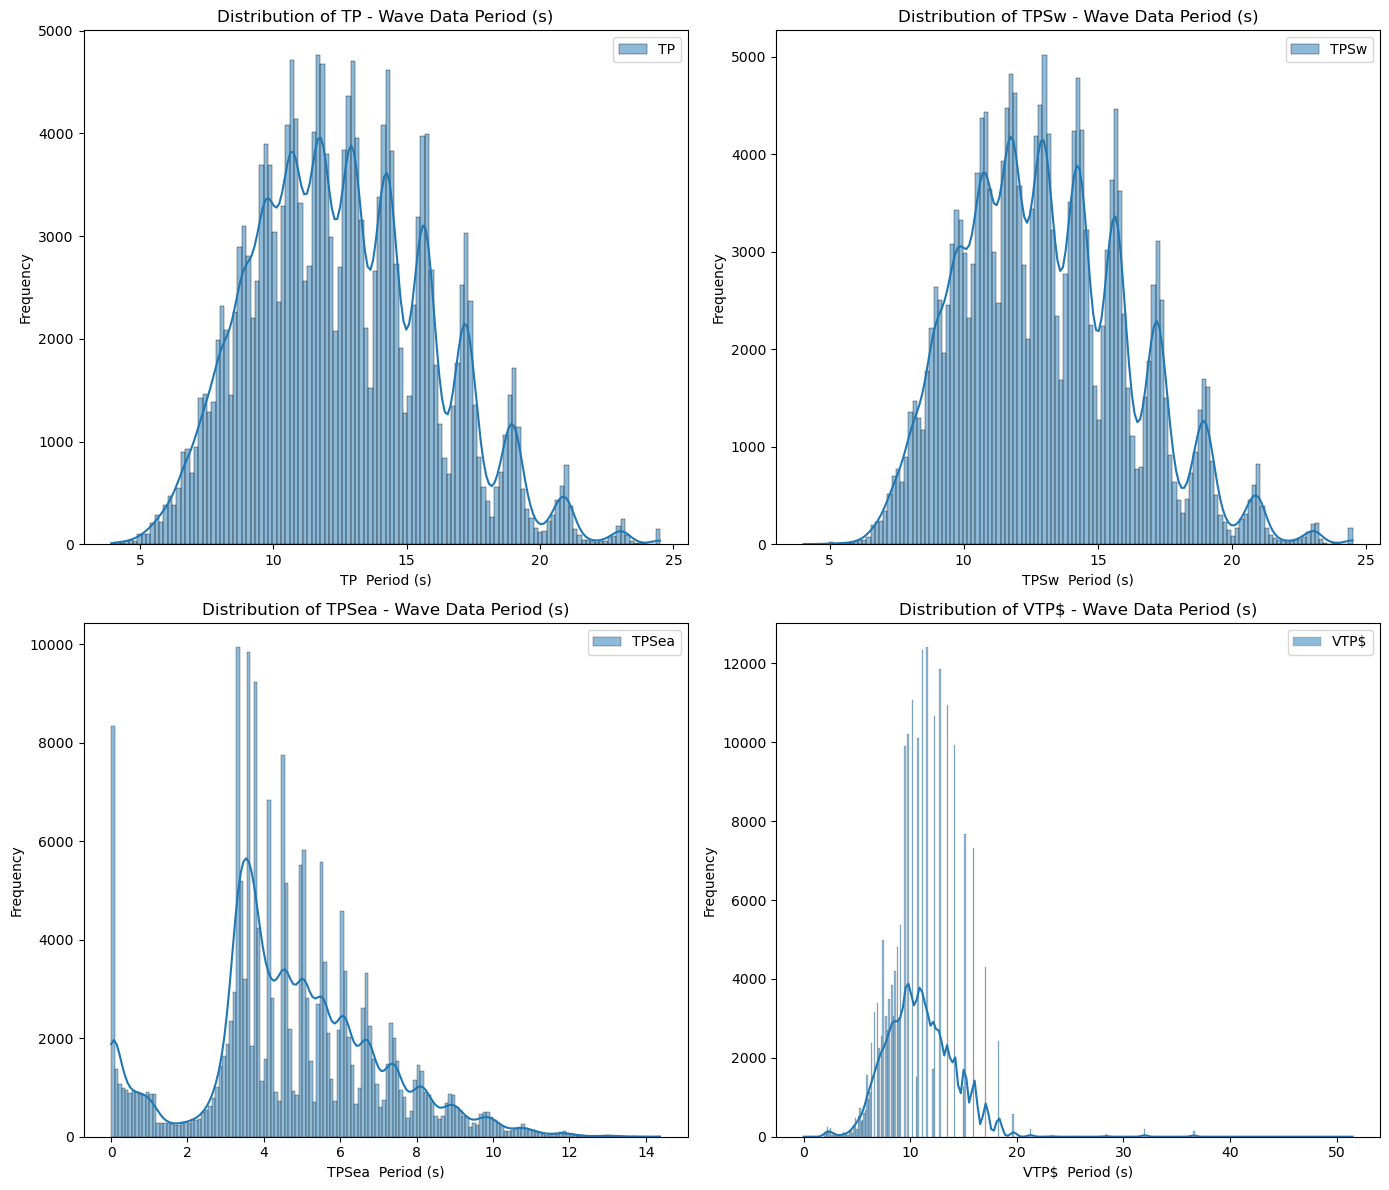

In [39]:
#Plot distributions of Wave Periods in units= seconds
columns_to_plot_waveperiod = ['TP','TPSw', 'TPSea','VTP$']
plot_distributions(columns_to_plot_waveperiod, xlabel_suffix = ' Period (s)')

In [40]:
main_df[['TP','TPSw', 'TPSea','VTP$']].describe()

,TP,TPSw,TPSea,VTP$
count,199026.000000,199026.000000,199026.000000,199026.000000
mean,12.640148,13.107230,4.673618,10.915365
std,3.359280,3.132854,2.310185,3.200322
min,3.909000,4.025000,0.000000,0.000000
25%,10.107000,10.742000,3.400000,8.800000
50%,12.408000,12.846000,4.521000,10.700000
75%,14.881000,15.314000,6.067000,12.800000
max,24.500000,24.500000,14.371000,51.500000


Looking at the distribution of wave period, Wave period from the hindcast data is little bit longer than the overall wave periods measured at the buoy. The wave period for the sea state(TPSea) is also shorter than the wave period for the swell(TPSw) which generally is to be expected, as local winds tend to generate higher frequency waves. (https://www.noaa.gov/jetstream/ocean/waves). 
- The kernel density fluctuations indicate periodic and different wave patterns/conditions. 
- Its possible the wave period generated from hindcast model shows a more generalized/consistent pattern compared to the wave period measured at the buoy. 

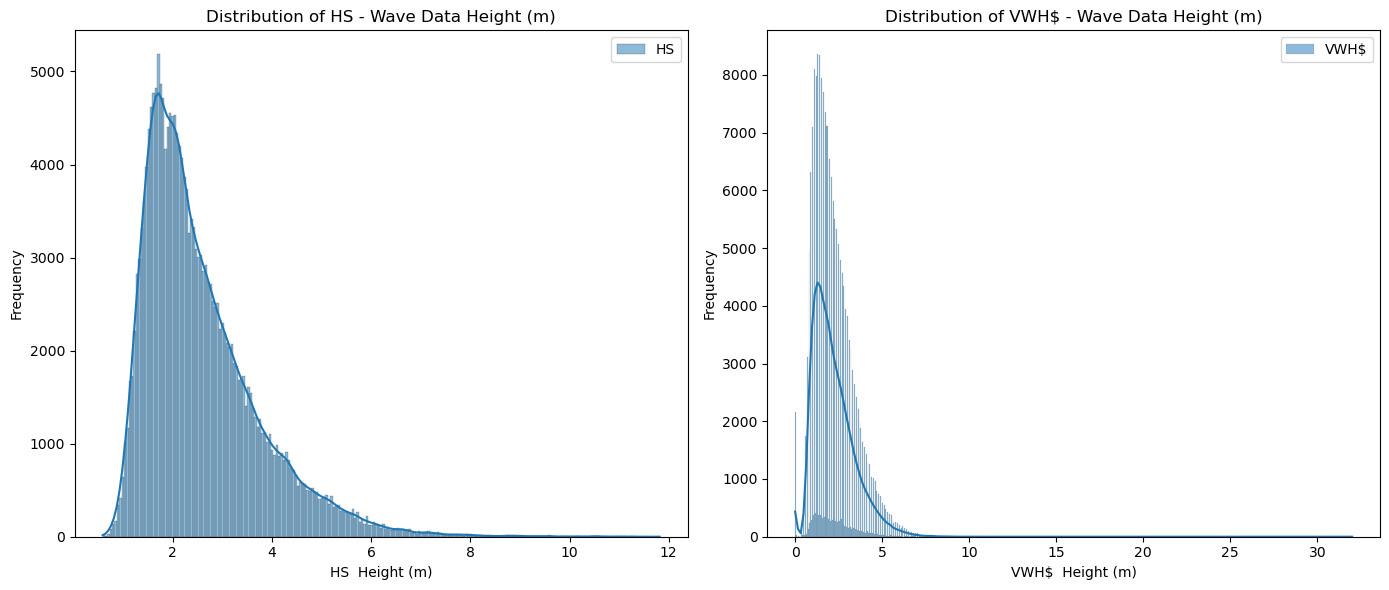

In [41]:
#Plot distributions of Wave Height  units= m
columns_to_plot_waveheight = ['HS','VWH$']
plot_distributions(columns_to_plot_waveheight, xlabel_suffix = ' Height (m)')

In [42]:
main_df[['HS','VWH$']].describe()

,HS,VWH$
count,199026.000000,199026.000000
mean,2.575444,2.191236
std,1.161033,1.180107
min,0.590000,0.000000
25%,1.733000,1.300000
50%,2.276000,1.900000
75%,3.132000,2.800000
max,11.816000,32.000000


Wave height is positively skewed for both measurements, mean > median. Outliers here do make sense, as weather patterns could generate unusually large waves. 

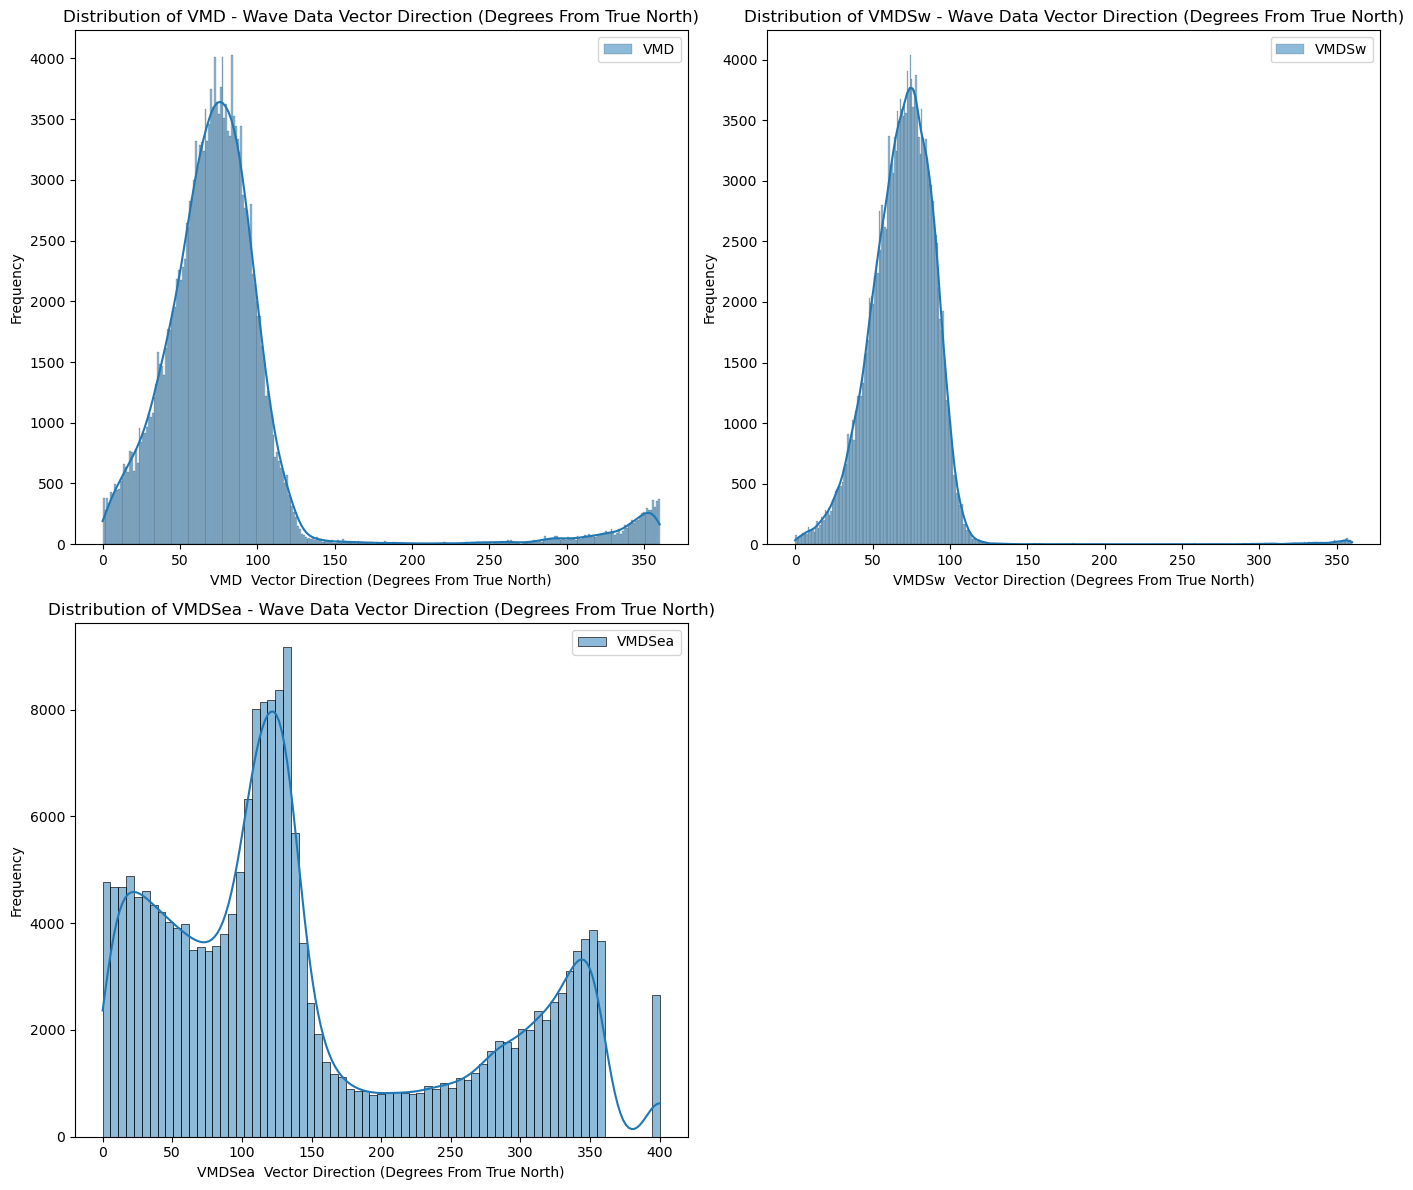

In [43]:
#Plot distributions of Wave Vector direction in units= degrees (True north) 
columns_to_plot_wavedirection = ['VMD','VMDSw','VMDSea']
plot_distributions(columns_to_plot_wavedirection, xlabel_suffix = ' Vector Direction (Degrees From True North)')

In [44]:
main_df[['VMD','VMDSw','VMDSea']].describe()

,VMD,VMDSw,VMDSea
count,199026.000000,199026.000000,199026.000000
mean,80.528525,69.897404,147.841545
std,58.264459,25.628558,109.439410
min,0.000000,0.000000,0.000000
25%,54.200000,56.500000,64.100000
50%,72.900000,70.700000,119.300000
75%,89.900000,83.200000,229.800000
max,360.000000,359.900000,400.000000


- Vector mean direction of waves is defined for this data as the direction waves are traveling towards. 
- Two peaks in Sea State vector mean direction could indicate sea swell being influenced by two main sources, could also indicate seasonal patterns, for example wind direction could predominantly change with season and since wind heavily influences the sea state this would be reflected. 
- The single peaks in overall vector direction of waves(VMD) and swell direction(VMDSw) around 50-90 degrees, indicate a predominant occurence of waves headed in a north east/east direction. This makes sense as it would imply waves coming from a southwest and west direction, which from my own observations of living close to the area where this data was collected, is correct. There are predominant southwest and west swells. 
- look into interaction between wind direction and sea sate swell direciton. 
- occurences at 400 degrees which does not exist; look into data points with this value. 

**Data points wtih VMDSea 400 degrees** 

North (N): 0° = 360°
East (E): 90°
South (S): 180°
West (W): 270°

Direction in which waves are travelling.

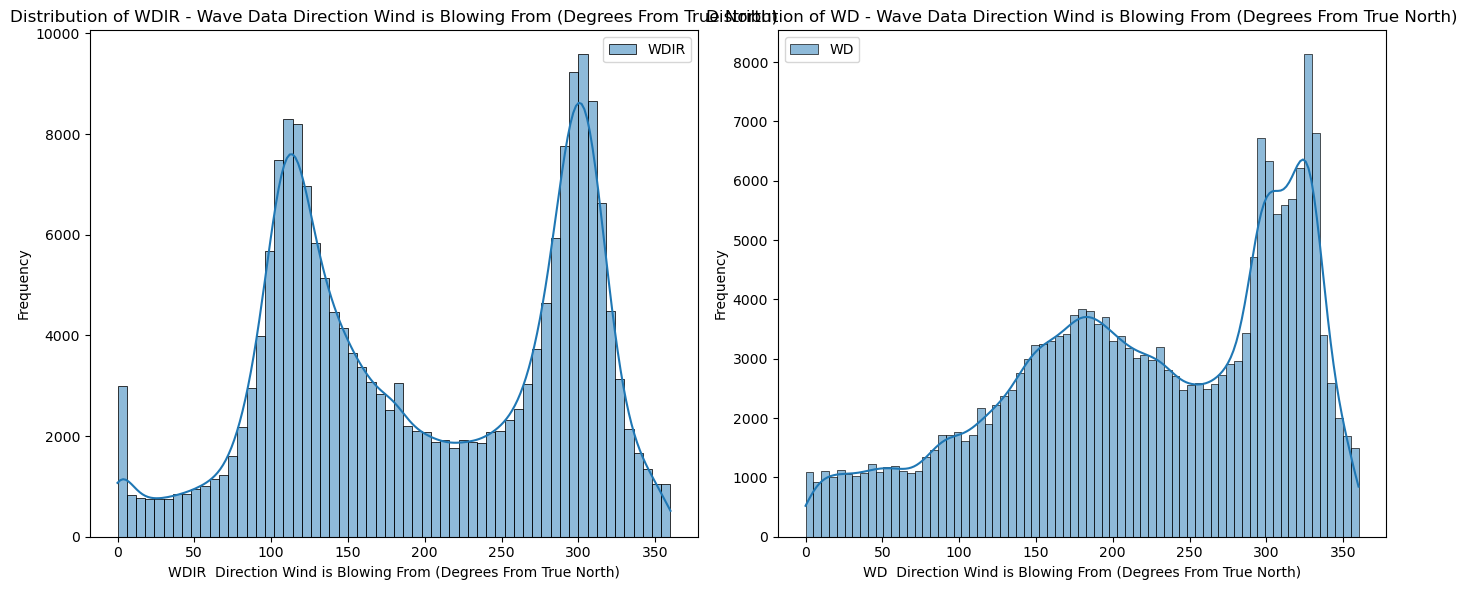

In [45]:
#Plot distributions of Wind direction in units= degrees (True north)
columns_to_plot_winddirection = ['WDIR','WD']
plot_distributions(columns_to_plot_winddirection, xlabel_suffix = ' Direction Wind is Blowing From (Degrees From True North)')

In [46]:
main_df[['WDIR','WD']].describe()

,WDIR,WD
count,199026.000000,199026.000000
mean,198.691126,220.946162
std,93.574420,91.812989
min,0.000000,0.000000
25%,117.000000,155.100000
50%,189.000000,229.300000
75%,293.000000,303.600000
max,360.000000,360.000000


- The wind direction values from hindacast model (WD) and measured buoy values (WDIR) roughly follow same approximate distribution, with 2 peaks indicating bimodal behavior and 2 predominant wind directions, although the directions are a little different between the two with the peak occuring before 150 degrees in the buoy measured wind direction, and the peak occuring after 150 degrees in hindcast data. This could also be due to slight difference in longtitude and latitude between buoy and gridpoint. Also this could indicate possible seasonal wind patterns. 
- WDIR: wind direction predominantly coming from:
    - 100-150 degrees,east-southeast to south-southeast
    - 300 degrees, west-northwest.
- WD: wind direction predominantly coming from: 
    - 150-200 degrees, south-southeast to south-southweset
    - 300 degrees, west-northwest.
- Two spikes in WDIR one around 0 degrees and another around 170. Check Q-Flag possibly for these observations. Also could indicate a really specific dominant wind directions. 

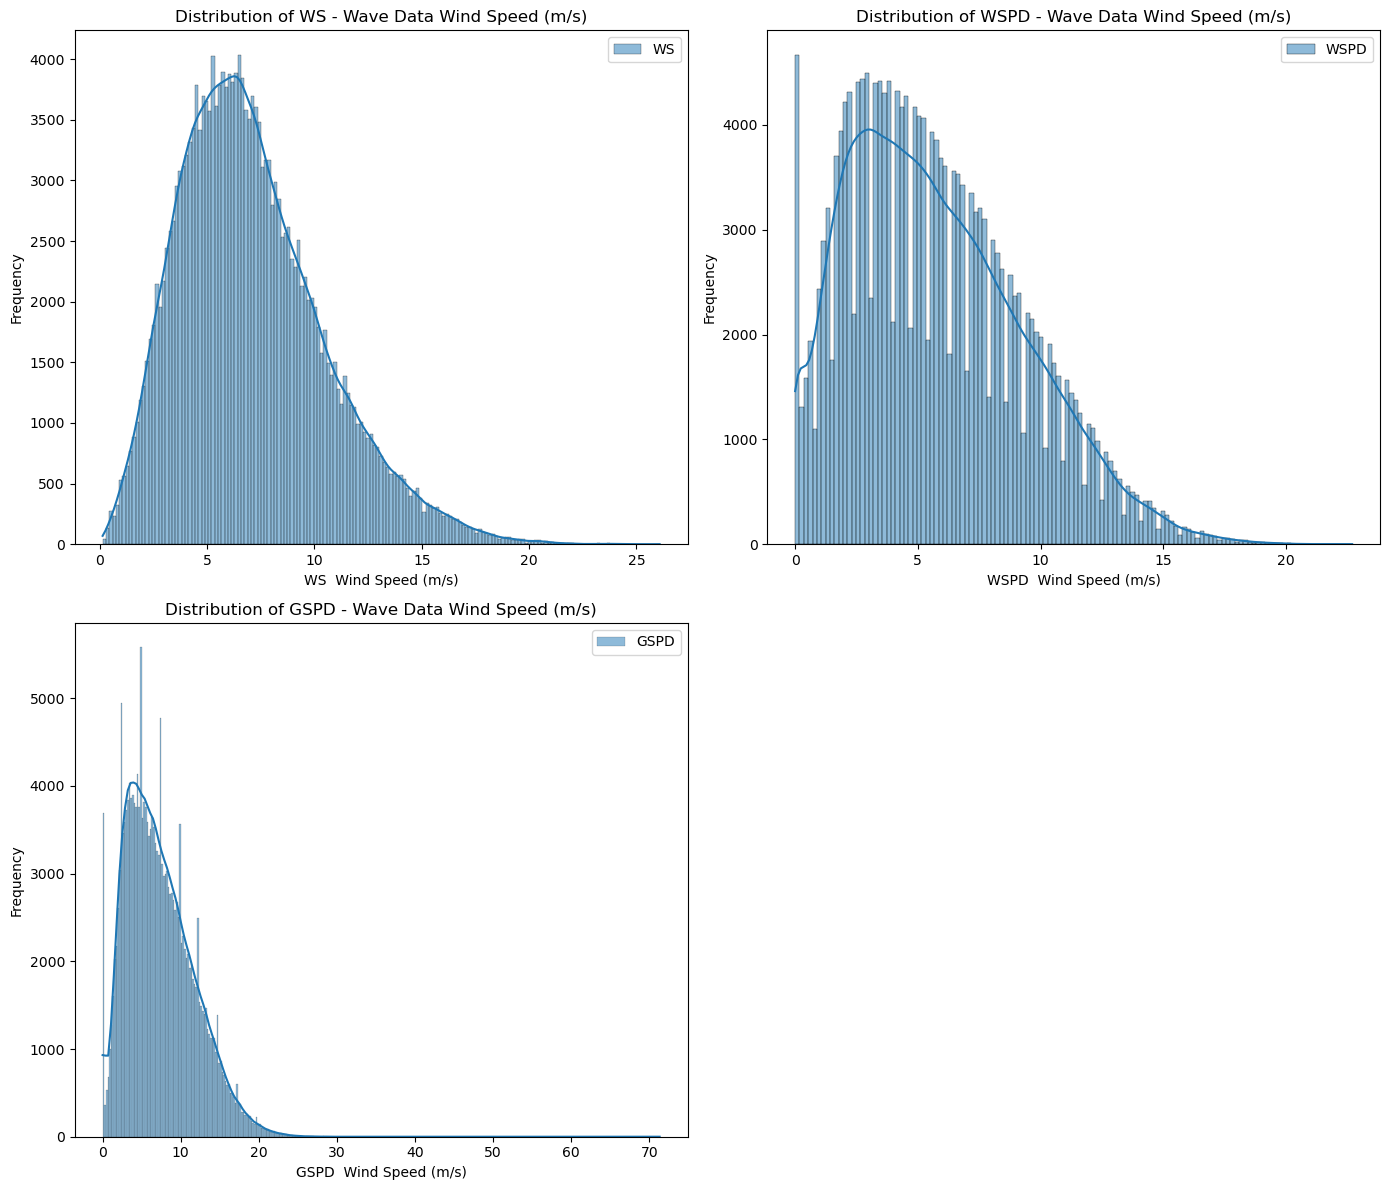

In [47]:
#Plot distributions of Wind Speed in units= m/s
columns_to_plot_windspeed= ['WS','WSPD','GSPD']
plot_distributions(columns_to_plot_windspeed, xlabel_suffix = ' Wind Speed (m/s)')

In [48]:
main_df[['WS','WSPD','GSPD']].describe()

,WS,WSPD,GSPD
count,199026.000000,199026.000000,199026.000000
mean,7.078606,5.746478,7.291796
std,3.410898,3.579220,4.326967
min,0.130000,0.000000,0.000000
25%,4.580000,2.900000,3.900000
50%,6.610000,5.200000,6.600000
75%,9.070000,8.100000,10.000000
max,26.080000,22.700000,71.300000


The distributions for wind speed and wind gust speed are positively skewed, for all three the mean>median. Lower wind speeds are more common. 
The kde falling in the middle of the distribution for Wind speed as measured by the buoy (WSPD) indicates multiple peaks in the data and could indicate distinct subgroups and patterns in wind speed. This could also reflect seasonality. 

### Correlations 

Look at linear relationships between variables.

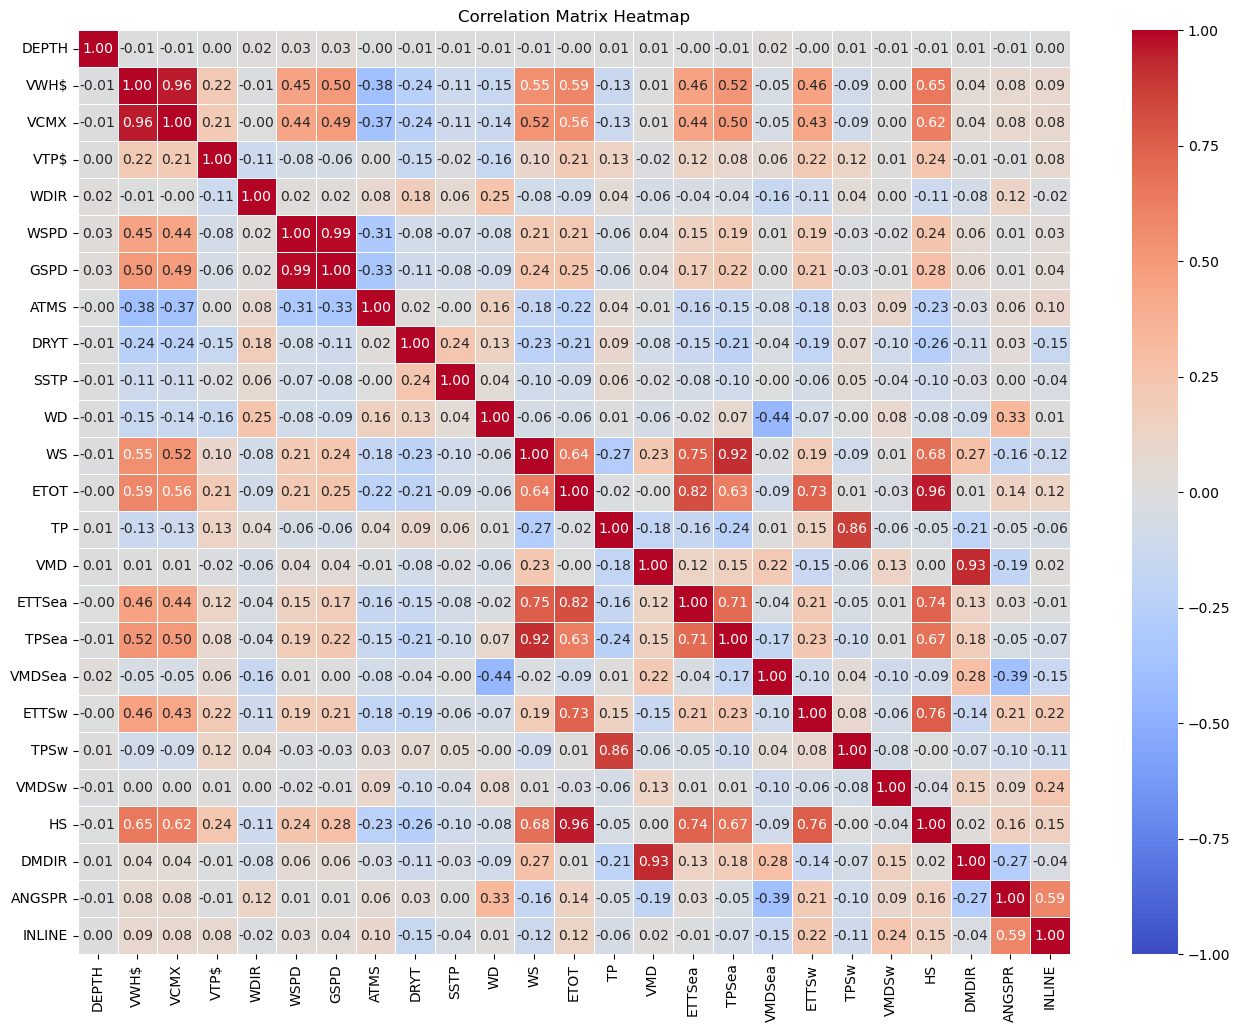

In [49]:
#plot correlation heat map 
# Exclude columns 
columns_to_exclude = ['DATE','Q_FLAG', 'STN_ID','Datetime_x','Datetime_y','WDIR.1','WSPD.1','GSPD.1','YEAR','MO1','MO2','LATITUDE','LONGITUDE']
columns_to_include = [col for col in main_df.columns if col not in columns_to_exclude]

# Create a DataFrame with only the selected columns
subset_df = main_df[columns_to_include]

# Plot the correlation matrix heatmap
plt.figure(figsize=(16, 12))
correlation_matrix = subset_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, vmin= -1, vmax =1)
plt.title('Correlation Matrix Heatmap')
plt.show()


In [50]:
#look at correlations with target variables, use function: 
from scipy.stats import pearsonr
def calculate_and_plot_correlations(data_frame, target_variable):
    # Select numeric columns for correlation
    numeric_columns = data_frame.select_dtypes(include='number')

    # Calculate correlations with the target variable
    correlations_overall = numeric_columns.corrwith(data_frame[target_variable]).drop(target_variable)
    
    # Calculate correlations and p-values with the target variable
    correlations, pvalues = [], []
    for col in numeric_columns.columns:
        if col != target_variable:
            corr, pval = pearsonr(numeric_columns[col], data_frame[target_variable])
            correlations.append(corr)
            pvalues.append(pval)
            print(f"CORR {col} vs {target_variable} = {corr:.3f} pval = {pval:.3f}")

    # Plot correlations
    plt.figure(figsize=(10, 6))
    colors = ['red' if corr > 0 else 'blue' for corr in correlations_overall]
    plt.barh(correlations_overall.index, correlations_overall.values, color=colors)
    plt.title(f'Correlation of features with target variable: {target_variable}')
    plt.xlim(-1, 1)
    plt.show()
    
    # Return correlations and p-values as a DataFrame
    result_df = pd.DataFrame({'Correlation': correlations, 'P-Value': pvalues}, index=numeric_columns.columns[:-1])
    return result_df

CORR Q_FLAG vs ETOT = 0.043 pval = 0.000
CORR LATITUDE vs ETOT = 0.007 pval = 0.004
CORR LONGITUDE vs ETOT = nan pval = nan
CORR DEPTH vs ETOT = -0.003 pval = 0.245
CORR VWH$ vs ETOT = 0.588 pval = 0.000
CORR VCMX vs ETOT = 0.558 pval = 0.000
CORR VTP$ vs ETOT = 0.211 pval = 0.000
CORR WDIR vs ETOT = -0.089 pval = 0.000
CORR WSPD vs ETOT = 0.212 pval = 0.000
CORR GSPD vs ETOT = 0.247 pval = 0.000
CORR WDIR.1 vs ETOT = -0.106 pval = 0.000
CORR WSPD.1 vs ETOT = 0.195 pval = 0.000
CORR GSPD.1 vs ETOT = 0.231 pval = 0.000
CORR ATMS vs ETOT = -0.220 pval = 0.000
CORR DRYT vs ETOT = -0.212 pval = 0.000
CORR SSTP vs ETOT = -0.086 pval = 0.000
CORR YEAR vs ETOT = -0.013 pval = 0.000
CORR WD vs ETOT = -0.059 pval = 0.000
CORR WS vs ETOT = 0.635 pval = 0.000
CORR TP vs ETOT = -0.024 pval = 0.000
CORR VMD vs ETOT = -0.001 pval = 0.781
CORR ETTSea vs ETOT = 0.820 pval = 0.000
CORR TPSea vs ETOT = 0.627 pval = 0.000
CORR VMDSea vs ETOT = -0.086 pval = 0.000
CORR ETTSw vs ETOT = 0.735 pval = 0.000
C

/Users/kamiasalango/anaconda3/envs/capstone_wavepower/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


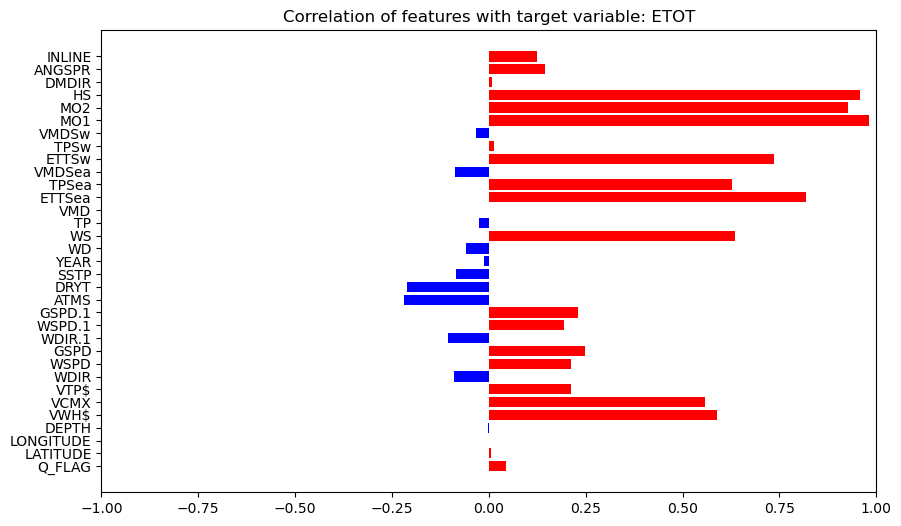

           Correlation        P-Value
Q_FLAG        0.043280   3.862150e-83
LATITUDE      0.006542   3.515743e-03
LONGITUDE          NaN            NaN
DEPTH        -0.002605   2.451913e-01
VWH$          0.587610   0.000000e+00
VCMX          0.557506   0.000000e+00
VTP$          0.211084   0.000000e+00
WDIR         -0.089274   0.000000e+00
WSPD          0.211871   0.000000e+00
GSPD          0.247117   0.000000e+00
WDIR.1       -0.105805   0.000000e+00
WSPD.1        0.194908   0.000000e+00
GSPD.1        0.231202   0.000000e+00
ATMS         -0.219997   0.000000e+00
DRYT         -0.211591   0.000000e+00
SSTP         -0.085626  1.962429e-320
YEAR         -0.013169   4.227134e-09
WD           -0.058984  7.289229e-153
WS            0.635186   0.000000e+00
ETOT         -0.024363   1.597148e-27
TP           -0.000623   7.810805e-01
VMD           0.819543   0.000000e+00
ETTSea        0.626970   0.000000e+00
TPSea        -0.086436   0.000000e+00
VMDSea        0.734992   0.000000e+00
ETTSw       

In [51]:
# look at correlations with ETOT: 
target_variable ='ETOT'
result_df_ETOT = calculate_and_plot_correlations(main_df,target_variable)
print(result_df_ETOT)

There are a lot of strong statistically significant correlations with target varibale. 
Variables of interest; 
- CORR VWH\$ vs ETOT = 0.588 pval = 0.000
- CORR VTP\$ vs ETOT = 0.211 pval = 0.000
- CORR WSPD vs ETOT = 0.212 pval = 0.000
- CORR GSPD vs ETOT = 0.247 pval = 0.000
- CORR ATMS vs ETOT = -0.220 pval = 0.000
- CORR DRYT vs ETOT = -0.212 pval = 0.000
- CORR WS vs ETOT = 0.635 pval = 0.000
- CORR ETTSea vs ETOT = 0.820 pval = 0.000
- CORR TPSea vs ETOT = 0.627 pval = 0.000
- CORR ETTSw vs ETOT = 0.735 pval = 0.000
- CORR HS vs ETOT = 0.959 pval = 0.000

Wave Height from hindcast data(HS) has very strong correlation with ETOT, may be sufficient to use HS as target variable if ETOT is derived from HS. 

### Correlations with variables and wave height, wave period

Look at correlations with variables that have significant influence on wave energy. 

CORR Q_FLAG vs VWH$ = -0.032 pval = 0.000
CORR LATITUDE vs VWH$ = 0.009 pval = 0.000
CORR LONGITUDE vs VWH$ = nan pval = nan
CORR DEPTH vs VWH$ = -0.010 pval = 0.000
CORR VCMX vs VWH$ = 0.959 pval = 0.000
CORR VTP$ vs VWH$ = 0.217 pval = 0.000
CORR WDIR vs VWH$ = -0.010 pval = 0.000
CORR WSPD vs VWH$ = 0.449 pval = 0.000
CORR GSPD vs VWH$ = 0.500 pval = 0.000
CORR WDIR.1 vs VWH$ = -0.027 pval = 0.000
CORR WSPD.1 vs VWH$ = 0.430 pval = 0.000
CORR GSPD.1 vs VWH$ = 0.480 pval = 0.000
CORR ATMS vs VWH$ = -0.384 pval = 0.000
CORR DRYT vs VWH$ = -0.244 pval = 0.000
CORR SSTP vs VWH$ = -0.110 pval = 0.000
CORR YEAR vs VWH$ = -0.036 pval = 0.000
CORR WD vs VWH$ = -0.149 pval = 0.000
CORR WS vs VWH$ = 0.550 pval = 0.000
CORR ETOT vs VWH$ = 0.588 pval = 0.000
CORR TP vs VWH$ = -0.135 pval = 0.000
CORR VMD vs VWH$ = 0.007 pval = 0.002
CORR ETTSea vs VWH$ = 0.461 pval = 0.000
CORR TPSea vs VWH$ = 0.523 pval = 0.000
CORR VMDSea vs VWH$ = -0.052 pval = 0.000
CORR ETTSw vs VWH$ = 0.456 pval = 0.000
C

/Users/kamiasalango/anaconda3/envs/capstone_wavepower/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


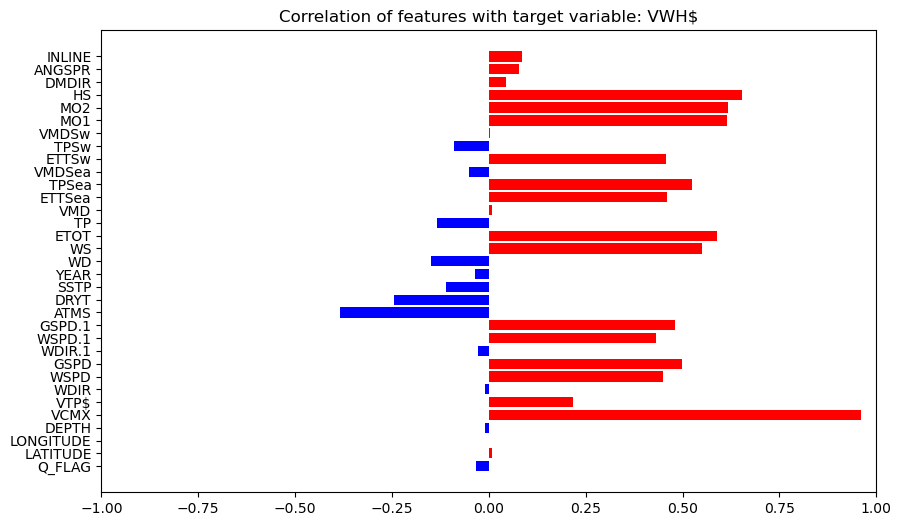

           Correlation        P-Value
Q_FLAG       -0.032066   1.922468e-46
LATITUDE      0.009399   2.750394e-05
LONGITUDE          NaN            NaN
DEPTH        -0.010411   3.403064e-06
VWH$          0.959187   0.000000e+00
VCMX          0.217439   0.000000e+00
VTP$         -0.010005   8.066036e-06
WDIR          0.449082   0.000000e+00
WSPD          0.499639   0.000000e+00
GSPD         -0.027473   1.514789e-34
WDIR.1        0.430404   0.000000e+00
WSPD.1        0.480358   0.000000e+00
GSPD.1       -0.384141   0.000000e+00
ATMS         -0.244057   0.000000e+00
DRYT         -0.110473   0.000000e+00
SSTP         -0.036093   2.278388e-58
YEAR         -0.148573   0.000000e+00
WD            0.549604   0.000000e+00
WS            0.587610   0.000000e+00
ETOT         -0.134948   0.000000e+00
TP            0.007001   1.788194e-03
VMD           0.460906   0.000000e+00
ETTSea        0.523219   0.000000e+00
TPSea        -0.051535  4.033252e-117
VMDSea        0.456344   0.000000e+00
ETTSw       

In [52]:
# look at correlations with VWH$(waveheight from buoy measurement): 
target_variable ='VWH$'
result_df_waveheight = calculate_and_plot_correlations(main_df,target_variable)
print(result_df_waveheight)

CORR Q_FLAG vs VTP$ = 0.041 pval = 0.000
CORR LATITUDE vs VTP$ = 0.014 pval = 0.000
CORR LONGITUDE vs VTP$ = nan pval = nan
CORR DEPTH vs VTP$ = 0.003 pval = 0.177
CORR VWH$ vs VTP$ = 0.217 pval = 0.000
CORR VCMX vs VTP$ = 0.208 pval = 0.000
CORR WDIR vs VTP$ = -0.114 pval = 0.000
CORR WSPD vs VTP$ = -0.078 pval = 0.000
CORR GSPD vs VTP$ = -0.057 pval = 0.000
CORR WDIR.1 vs VTP$ = -0.102 pval = 0.000
CORR WSPD.1 vs VTP$ = -0.079 pval = 0.000
CORR GSPD.1 vs VTP$ = -0.058 pval = 0.000
CORR ATMS vs VTP$ = 0.004 pval = 0.111
CORR DRYT vs VTP$ = -0.149 pval = 0.000
CORR SSTP vs VTP$ = -0.021 pval = 0.000
CORR YEAR vs VTP$ = -0.090 pval = 0.000
CORR WD vs VTP$ = -0.156 pval = 0.000
CORR WS vs VTP$ = 0.099 pval = 0.000
CORR ETOT vs VTP$ = 0.211 pval = 0.000
CORR TP vs VTP$ = 0.128 pval = 0.000
CORR VMD vs VTP$ = -0.018 pval = 0.000
CORR ETTSea vs VTP$ = 0.122 pval = 0.000
CORR TPSea vs VTP$ = 0.078 pval = 0.000
CORR VMDSea vs VTP$ = 0.058 pval = 0.000
CORR ETTSw vs VTP$ = 0.216 pval = 0.000
C

/Users/kamiasalango/anaconda3/envs/capstone_wavepower/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


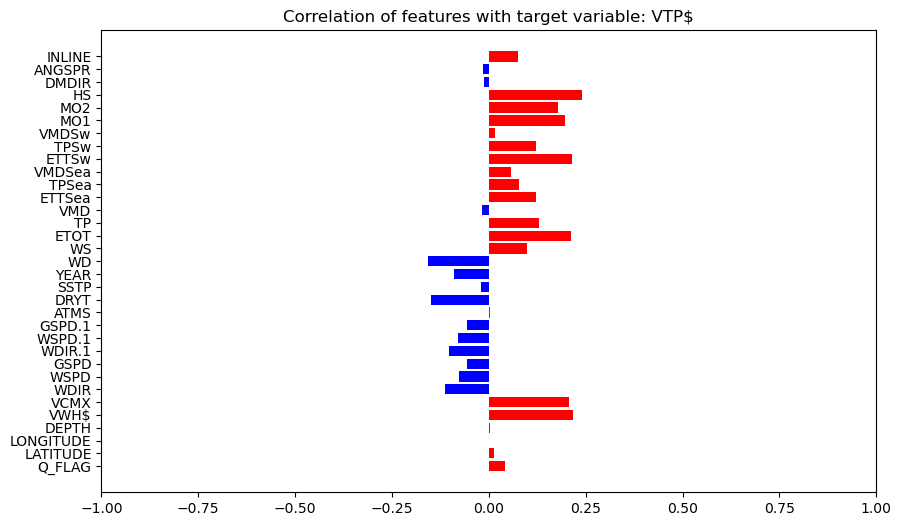

           Correlation        P-Value
Q_FLAG        0.041114   3.316485e-75
LATITUDE      0.014032   3.846354e-10
LONGITUDE          NaN            NaN
DEPTH         0.003026   1.769561e-01
VWH$          0.217439   0.000000e+00
VCMX          0.208104   0.000000e+00
VTP$         -0.114341   0.000000e+00
WDIR         -0.077763  1.677616e-264
WSPD         -0.056759  1.101449e-141
GSPD         -0.102261   0.000000e+00
WDIR.1       -0.078587  4.194955e-270
WSPD.1       -0.057572  1.014871e-145
GSPD.1        0.003571   1.111563e-01
ATMS         -0.148929   0.000000e+00
DRYT         -0.021152   3.819572e-21
SSTP         -0.090016   0.000000e+00
YEAR         -0.156167   0.000000e+00
WD            0.098635   0.000000e+00
WS            0.211084   0.000000e+00
ETOT          0.128216   0.000000e+00
TP           -0.018183   4.960584e-16
VMD           0.121961   0.000000e+00
ETTSea        0.078351  1.718598e-268
TPSea         0.058310  1.970971e-149
VMDSea        0.215528   0.000000e+00
ETTSw       

In [53]:
#Look at correlations with VTP$, wave period measured from buoy
target_variable ='VTP$'
result_df_waveperiod = calculate_and_plot_correlations(main_df,target_variable)
print(result_df_waveperiod)

There are statistically significant correlations with other variables and wave energy as well as wave period. This indicates interactions within variables in the data set. Next do Lasso Regression to assess predictor variables for ETOT and regularize and reduce effects of multicollinearity. 

## Lasso Regression

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

#define X and y
X = main_df.drop(['ETOT','STN_ID','Datetime_x','Datetime_y','DATE'], axis =1)
y = main_df['ETOT']

#split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#instantiat,fit model and test
lasso_reg_model = Lasso(alpha=0.001)
lasso_reg_model.fit(X_train_scaled, y_train)

# predict on the test set
y_pred = lasso_reg_model.predict(X_test_scaled)

# calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# get coefficients
coefficients_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': lasso_reg_model.coef_})
non_zero_coeff_df = coefficients_df[abs(coefficients_df['Coefficient']) > 0]
# Print DataFrame of coefficients
print(non_zero_coeff_df)





Mean Squared Error: 5.789725890163376e-06
   Feature  Coefficient
21  ETTSea     0.348073
24   ETTSw     0.297540
27     MO1     0.013478


Sea State and Swell are predictors for Wave energy. Look into what influences sea state and swell. 

## Temporal Patterns

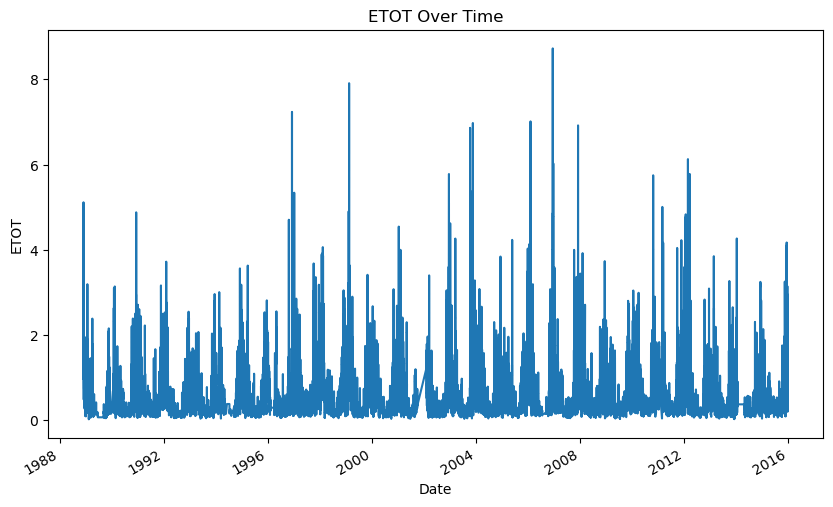

In [55]:
main_df.set_index('DATE', inplace=True)

# Plotting ETOT
plt.figure(figsize=(10, 6))
main_df['ETOT'].plot()
plt.title('ETOT Over Time')
plt.xlabel('Date')
plt.ylabel('ETOT')
plt.show()



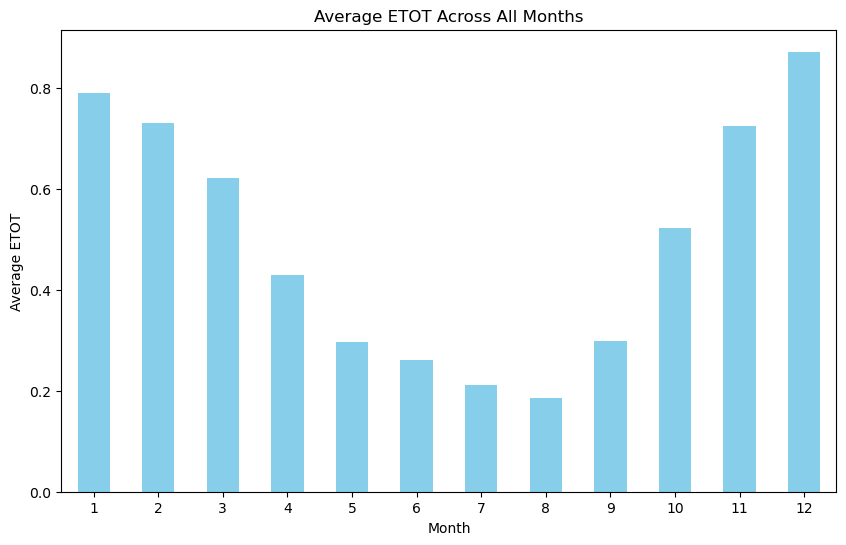

In [56]:
# Calculate average ETOT for each month
monthly_data = main_df.groupby(main_df.index.month)['ETOT'].mean()

# Plot the average ETOT
plt.figure(figsize=(10, 6))
monthly_data.plot(kind='bar', color='skyblue')
plt.title('Average ETOT Across All Months')
plt.xlabel('Month')
plt.ylabel('Average ETOT')
plt.xticks(rotation=0)
plt.show()



In [57]:
#remember to reset index

There seems to be temporal trends in wave energy. There is increased wave energy in the winter and decreased wave energy in the summer. Next steps, install statsmodels in enviroment and use seasonal decompose to decompose ETOT as time series. 

## Summary: 
In Summary thus far correlations between variables and with target variable(s) have been found. Sea state wind swell and greater longer period swell are strong predictors of ETOT. This can be expected as this is what makes up ETOT. Sea state and swell combined create wave energy. Moving forward, the relationships between other variables and ETTSea and ETTsw will be analyzed, to see what will predict these variables and what features to include in machine learning model. Perhaps model will be to predict these two variables instead of ETOT. Temporal patterns are present in the data. Time series analyisis will also be done next, to see if variables can be predicted with time series and if time series can be incorporated into model. 

Possible features to add: 
- Consideration of possible feature to add to take into account the slight difference in distance of buoy and gridpoint. 
- A feature that may be added is tidal patterns, this data however is measured from a station from land. 
- Moonphase feature might be added at later stage. 
- possible inclusion of bathymmetry data. 

As of now, the exact model that will be used is unclear. Perhaps a Random Forest Model. 
More Hindcast data from close by girdpoints is avaialbale, as well as data of wave height and wave period from 
a buoy closer to shore. 

In [58]:
main_df.shape


(199026, 37)